In [554]:
import glob
import os
import re
import sys
import warnings

from astropy import modeling
from astropy.convolution import convolve, Gaussian2DKernel, convolve_fft
from astropy.coordinates import FK5, SkyCoord
import astropy.io.fits as pyfits
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats, mad_std
from astropy.time import Time
import astropy.units as u
from astropy.visualization import SqrtStretch, SinhStretch, MinMaxInterval, PercentileInterval, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS

import csv

import datetime

import math

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import photutils as pt
from photutils import DAOStarFinder, find_peaks, aperture_photometry, CircularAperture

from progress.bar import ChargingBar

from scipy import stats
import scipy.signal
import scipy.optimize as optimize

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])


ModuleNotFoundError: No module named 'drizzlepac'

In [491]:
# ignore overwriting reduced files warnings in case you need to rerun
warnings.filterwarnings('ignore', message='Overwriting existing file')

# ignore overflow errors
warnings.filterwarnings('ignore', message='overflow encountered in sinh')

# ignore everything, maybe don't do this?
warnings.filterwarnings('ignore')


### Tell me where your raw data is.

In [528]:
raw_data_direc = input ("Enter the directory where your data is stored: ")
test_direc = str(raw_data_direc)
print("The directory you entered is:", test_direc)


Enter the directory where your data is stored: /Users/Hannah/iraf/images/2017Q4UV01/UT171117/ARCTIC/
The directory you entered is: /Users/Hannah/iraf/images/2017Q4UV01/UT171117/ARCTIC/


### And what filter(s) you observed in.

In [529]:
filt_list = []

n_filt = input ("How many filters did you observe in? ")

for i in np.arange(int(n_filt)):
    filt = input ("Enter the {} filter you observed in: ".format(ordinal(i+1)))

    filt_list.append(str(filt))

for i in np.arange(int(n_filt)):
    if i == 0:
        print("The filters you entered are:")
        print(filt_list[i])
    else:
        print(filt_list[i])

How many filters did you observe in? 2
Enter the 1st filter you observed in: u
Enter the 2nd filter you observed in: g
The filters you entered are:
u
g


### Image Reduction -- Creates /reduced/cals/ and /reduced/data/ directories, and fills those directories with reduced calibration and science images.

In [547]:
cals_direc = os.path.join(raw_data_direc, 'reduced', 'cals')
reduced_direc = os.path.join(raw_data_direc, 'reduced', 'data')

# directories for reduced images
if not os.path.exists(cals_direc):
    os.makedirs(cals_direc)
if not os.path.exists(reduced_direc):
    os.makedirs(reduced_direc) 

# grab all files from the data directory; organize dataframe
files = sorted(glob.glob(os.path.join(raw_data_direc, "*.fits")))

df = pd.DataFrame(files,columns=['fname'])
df['objtype'] = pd.Series("", index=df.index)
df['filt'] = pd.Series("", index=df.index)
df['exp'] = pd.Series("", index=df.index)
df['objname'] = pd.Series("", index=df.index)

for ff,fname in enumerate(files):
    try:
        df['objtype'][ff] = pyfits.open(fname)[0].header['IMAGETYP']
        df['filt'][ff] = pyfits.open(fname)[0].header['FILTER']
        df['exp'][ff] = pyfits.open(fname)[0].header['EXPTIME']
        df['objname'][ff] = pyfits.open(fname)[0].header['OBJNAME']
    except IOError:
        print('\n File corrupt or missing: ' + fname)
        

#### Overscan correction

In [495]:
def trim_image(f, overscan_poly_order = 5):
    """
    trim_image returns a trimmed version of the raw image. The ARCTIC detector is structured in four quadrants which can be read out individually (Quad Mode) or as a whole (Lower Left Mode) and trim_image identifies which readout mode was used and crops the image accordingly.
        
    Parameters
    ----------
    f : raw fits image from ARCTIC
    overscan_poly_order : order of polynomial used to fit overscan
        
    Returns
    -------
    alldat : a list with [the image in a numpy array, the astropy header]
    """
    
    datfile = pyfits.getdata(f, header=True)
    dat_raw = datfile[0]
    dat_head = datfile[1]
    
    amp = pyfits.open(f)[0].header['READAMPS']
    
    if amp == "Quad":
        # ll, ul, lr, ur
        quads = ['DSEC11', 'DSEC21', 'DSEC12', 'DSEC22']
        biases = ['BSEC11', 'BSEC21', 'BSEC12', 'BSEC22']
        
        dat = [[],[],[],[]]
        for i,quad in enumerate(quads):
            idx_string = pyfits.open(f)[0].header[quad]
            idx = re.split('[: ,]',idx_string.rstrip(']').lstrip('['))
            dat[i] = dat_raw[int(idx[2])-1:int(idx[3]),int(idx[0])-1:int(idx[1])].astype(np.float64)
    
        over = [[],[],[],[]]
        avg_overscan = [[],[],[],[]]
        row_idx = [[],[],[],[]]
        p = [[],[],[],[]]
        fit_overscan = [[],[],[],[]]
        fit_overscan_col = [[],[],[],[]]
        
        for j,bias in enumerate(biases):
            idx_over_string = pyfits.open(f)[0].header[bias]
            idx_over = re.split('[: ,]',idx_over_string.rstrip(']').lstrip('['))
            over[j] = dat_raw[int(idx_over[2])-1:int(idx_over[3]),int(idx_over[0])-1:int(idx_over[1])]
            
            #Average along columns
            avg_overscan[j] = np.mean(over[j],axis=1)
            #Index array, then fit!
            row_idx[j] = np.arange(len(avg_overscan[j]))
            p[j] = np.polyfit(row_idx[j],avg_overscan[j],deg=overscan_poly_order)
            #Calculate array from fit, then transpose into a column
            fit_overscan[j] = np.poly1d(p[j])(row_idx[j])
            fit_overscan_col[j] = fit_overscan[j][:,np.newaxis]
        
        #Subtract column!
        dat[0] -= fit_overscan_col[0]
        dat[1] -= fit_overscan_col[1]
        dat[2] -= fit_overscan_col[2]
        dat[3] -= fit_overscan_col[3]
        
        sci_lo = np.concatenate((dat[2], dat[3]), axis = 1)
        sci_up = np.concatenate((dat[0], dat[1]), axis = 1)
        sci = np.concatenate((sci_up, sci_lo), axis = 0)

    if amp == 'LL':
        idx_string = pyfits.open(f)[0].header['DSEC11']
        idx = re.split('[: ,]',idx_string.rstrip(']').lstrip('['))
        sci = dat_raw[int(idx[2])-1:int(idx[3]),int(idx[0])-1:int(idx[1])].astype(np.float64)
    
        idx_over_string = pyfits.open(f)[0].header['BSEC11']
        idx_over = re.split('[: ,]',idx_over_string.rstrip(']').lstrip('['))
        over = dat_raw[int(idx_over[2])-1:int(idx_over[3]),int(idx_over[0])-1:int(idx_over[1])]
        
        #Average along columns
        avg_overscan = np.mean(over,axis=1)
        #Index array, then fit!
        row_idx = np.arange(len(avg_overscan))
        p = np.polyfit(row_idx,avg_overscan,deg=overscan_poly_order)
        #Calculate array from fit, then transpose into a column
        fit_overscan = np.poly1d(p)(row_idx)
        fit_overscan_col = fit_overscan[:,np.newaxis]
        #Subtract column!
        sci -= fit_overscan_col
    
    alldat = [sci,dat_head]
    return alldat

#### Scale darks

In [496]:
def getdark(expt):
    """
    Generate a dark given an exposure time or scale down from longest dark available
        
    Parameters
    ----------
    expt : exposure time (in the data frame: df['exp'])
        
    Returns
    -------
    dark : dark image for that exposure time (numpy array)
    """
    
    try:
        dark = pyfits.getdata(os.path.join(cals_direc,'master_dark_{0}.fits'.format(expt)))
    except IOError:
        scaleto = np.max(df['exp'][df['exp'] != ''])
        dark = pyfits.getdata(os.path.join(cals_direc,'master_dark_{0}.fits'.format(scaleto)))
        dark *= (expt/scaleto)
    return dark

#### Bias combine

In [497]:
### CREATE MASTER BIAS #######################################

print('\n >>> Starting bias combine...')

bias_idx = df[df['objtype'] == 'Bias'].index.tolist()

if len(bias_idx) == 0:
    print('   > No biases found. Continuing reductions...')
    bias=0.
else:
    biases = np.array([trim_image(df['fname'][n])[0] for n in bias_idx])
    bias = np.median(biases,axis=0)
    pyfits.writeto(os.path.join(cals_direc, 'master_bias.fits'),bias,overwrite=True)
    print('   > Created master bias')



 >>> Starting bias combine...
   > Created master bias


#### Dark combine

In [498]:
### CREATE MASTER DARKS ######################################
### these are bias subtracted

# array of all exposure times found
times = list(filter(None,pd.unique(df.exp.ravel())))

print('\n >>> Starting darks...')

for ii in range(0,len(times)):
    dark_idx = df[(df['exp'] == times[ii]) & (df['objtype'] == 'Dark')].index.tolist()
    
    if len(dark_idx) == 0:
        print('   > No darks found for exposure time ' + str(times[ii]) + ' sec. Continuing reductions...')
    else:
        darks = np.array([trim_image(df['fname'][n])[0] for n in dark_idx]) - bias
        dark_final = np.median(darks,axis=0)
        
        name = os.path.join(cals_direc,'master_dark_{0}.fits'.format(times[ii]))
        pyfits.writeto(name,dark_final,overwrite=True)
        print('   > Created master '+ str(times[ii])+' second dark')


 >>> Starting darks...
   > Created master 1800.0 second dark
   > No darks found for exposure time 180.0 sec. Continuing reductions...
   > No darks found for exposure time 8.0 sec. Continuing reductions...
   > No darks found for exposure time 20.0 sec. Continuing reductions...
   > No darks found for exposure time 40.0 sec. Continuing reductions...


#### Flat combine (multiple filters)

In [499]:
### CREATE MASTER FLATS ######################################
### these are bias and dark subtracted, then normalized

# array of all filters found
filters = list(filter(None,pd.unique(df.filt.ravel())))

print('\n >>> Starting flats...')

for ii in range(0,len(filters)):
    flat_idx = df[(df['filt'] == filters[ii]) & (df['objtype'] == 'Flat')].index.tolist()
    
    if len(flat_idx) == 0:
        print('   > No flats found for the ' + str(filters[ii]) + ' filter. Continuing reductions...')
    else:
        # get the correct master dark. if not exact exp time, scale it
        # from the longest dark frame. if no darks at all, continue.
        expt = df['exp'][flat_idx[0]]
        if expt > 60.0:
            try:
                dark = getdark(expt)
            except IOError:
                print('   > No darks found for exposure time ' + str(expt) + ' sec. Continuing reductions...')
                dark = 0.
        else:
            print('   > Exposure time ' + str(expt) + ' sec. No dark correction neccessary.')
            dark = 0.

        flats = np.array([trim_image(df['fname'][n])[0] for n in flat_idx]) - bias - dark
        flat_final = np.median(flats,axis=0)
        flat_final /= np.max(flat_final)

        new_filter_name = filters[ii].strip("#2")
        filts = new_filter_name[-1]
        name = os.path.join(cals_direc, 'master_flat_{0}.fits'.format(filts))
        pyfits.writeto(name,flat_final,overwrite=True)
        print('   > Created master '+ str(new_filter_name[-1])+' flat')


 >>> Starting flats...
   > No flats found for the Semrock filter. Continuing reductions...
   > Created master u flat
   > Exposure time 8.0 sec. No dark correction neccessary.
   > Created master g flat


#### Dark, bias, and flat correct science images

In [500]:
### REDUCE SCIENCE IMAGES ####################################
### (raw - dark) / masterflat

dat_idx = df[df['objtype'] == 'Object'].index.tolist()

print('\n >>> '+str(len(dat_idx))+' science images found. Starting reductions...')
for n in dat_idx:
    datfile = trim_image(df['fname'][n])
    dat_raw = datfile[0]
    dat_head = datfile[1]
    
    time = df['exp'][n]
    if time > 60.0:
        try:
            dark = getdark(time)
        except IOError:
            print('   > No darks found for exposure time ' + str(time) + ' sec. Continuing reductions...')
            dark = 0.
    else:
        print('   > Exposure time ' + str(time) + ' sec. No dark correction necessary.')
        dark = 0.

    new_filter_name = df['filt'][n].strip("#2")
    filt = new_filter_name[-1]
    try:
        flat = flat = pyfits.getdata(os.path.join(cals_direc,'master_flat_{0}.fits'.format(filt)))
    except IOError:
        print('   > Warning! No ' + str(new_filter_name) + ' filter flat found for ' + df['fname'][n])
        flat = 1.
    
    dat = (dat_raw - dark) / flat
    name = os.path.join(reduced_direc,'red_{0}'.format(os.path.basename(df['fname'][n])))
    pyfits.writeto(name,dat,overwrite=True,header=dat_head)

print('\n >>> Finished reductions!')


 >>> 335 science images found. Starting reductions...
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
 

   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessar

   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessary.
   > Exposure time 40.0 sec. No dark correction necessary.
   > Exposure time 20.0 sec. No dark correction necessar

### Photometry -- Performs aperture photometry on science images in the /reduced/data/ directory for multiple filters.

In [548]:
cals_direc = os.path.join(raw_data_direc, 'reduced', 'cals')
reduced_direc = os.path.join(raw_data_direc, 'reduced', 'data')
results_direc = os.path.join(reduced_direc, 'results')

# directories for reduced images
if not os.path.exists(cals_direc):
    print('   > Reduced cals directory does not exist! Run cells above (Image Reduction section) first.')
if not os.path.exists(reduced_direc):
    print('   > Reduced data directory does not exist! Run cells above (Image Reduction section) first.')
if not os.path.exists(results_direc):
    os.makedirs(results_direc)
    
red_files = sorted(glob.glob(os.path.join(reduced_direc, "*.fits")))
    

#### Find peak of Gaussian

In [502]:
def update_coords(img, x_guess, y_guess, mask_max_counts=65000, box_width=70, plot_fit=False, smooth=True, kernel_size=10.):
    
    '''
    img: 2D array. Should be the image you are analyzing
        x_guess: int, 1st guess for the x coordinate. Needs to be closer than box_width
        y_guess: int, 1st guess for the y coordinate. Needs to be closer than box_width
        mask_max_counts: Set all points with counts higher than this number equal to the median
        box_width: int,  The area to consider for the stars coordinates. Needs to be small enough to not include
            extra stars, but big enough not to include errors on your x,y guess
    plot_fit: bool, show a plot to the gauss fit?
        smooth: bool, convolve image with gaussian first? The advantage of this is that it will take out some
            of the errors caused by the image being a donut instead of a gaussian. Especially useful for
            non-uniform PSFs, such as ARCSAT's defocused image. For ARCTIC, this may not be necessary.
            Try it anyway though!
        kernel_size: float, standard deviation of gaussian kernel used to smooth data (pixels). Irrevelvant
            if smooth is set to False
    '''
    box_size = int(box_width/2)
    
    x_guess = int(x_guess)
    y_guess=int(y_guess)
    # cutout the part of the image around the star of interest
    stamp = img[y_guess-box_size:y_guess+box_size,x_guess-box_size:x_guess+box_size ].astype(np.float64)
    cutout = np.copy(stamp)

    # change saturated pixels to 0, so it doesn't throw off fit
    cutout[cutout>mask_max_counts] = 0.

    if smooth:
        # Convolve image with gaussian kernel to limit the noise
        gauss_kernel = Gaussian2DKernel(kernel_size)
        cutout = convolve(cutout, gauss_kernel, boundary='extend')
    else:
        cutout_s = cutout
        # Subtract sky background
    cutout -= np.median(cutout)
    
    # Sum pixels in x,y directions
    x_sum = np.sum(cutout, axis=0)
    y_sum = np.sum(cutout, axis=1)
    
    # Fit a gaussian to the x and y summed columns
    offset = np.arange(box_width)-box_size
    fitter = modeling.fitting.LevMarLSQFitter()
    model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
    fitted_x = fitter(model, offset, x_sum)
    fitted_y = fitter(model, offset, y_sum)
    
    # Add the offset from the fitted gaussian to the original guess
    
    x_cen = x_guess + fitted_x.mean
    y_cen = y_guess + fitted_y.mean
    x_diff = x_cen - x_guess
    y_diff = y_cen - y_guess

    #print("X Guess : %.2f ; X Corrected To : %.2f ; Difference Of : %.2f" % (x_guess, x_cen, x_diff))
    #print("Y Guess : %.2f ; Y Corrected To : %.2f ; Difference Of : %.2f" % (y_guess, y_cen, y_diff))

    if plot_fit:
    
        f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    
        ax1.plot(offset, x_sum, 'o', color='C0', label='x offset')
        ax1.plot(offset, y_sum, 'o', color='C1', label='y offset')
    
        ax1.plot(offset, fitted_x(offset), 'C0')
        ax1.plot(offset, fitted_y(offset), 'C1')
    
        ax1.legend()
    
        m,s = np.median(stamp), np.std(stamp)
        ax2.imshow(stamp, vmin=m-s, vmax=m+s, origin='lower', cmap='Greys_r', interpolation='nearest',
        extent=[-box_size,box_size,-box_size,box_size])
        ax2.plot(fitted_x.mean, fitted_y.mean, 'ro', label='updated')
        ax2.plot(0,0, 'bo', label='guess')
        ax2.legend()
    
        ax3.imshow(img, vmin=m-s, vmax=m+s, origin='lower', cmap='Greys_r', interpolation='nearest',)
        ax3.plot(x_cen, y_cen, 'ro', markersize=1)
        ax3.plot(x_guess, y_guess, 'bo', markersize=1)
    
        plt.tight_layout()
        plt.savefig(os.path.join(results_direc,str(img[-8])+'.pos.png'))
        plt.close()
        plt.close()
        plt.close()
        
    return x_cen, y_cen
        

### Tell me where (x,y position) your star of interest is (i.e., the star with an eclipsing body) in your science images.

In [503]:
x_list, y_list = [],[]

exopl_x = input ("Enter the x position of your star of interest: ")
exopl_y = input ("Enter the y position of your star of interest: ")

x_list.append(float(exopl_x))
y_list.append(float(exopl_y))
print("The position you entered is:", x_list[0], ",", y_list[0])

Enter the x position of your star of interest: 1093
Enter the y position of your star of interest: 363
The position you entered is: 1093.0 , 363.0


### Tell me the other x,y positions of your references stars.

In [504]:
n_ref = input ("How many reference stars do you have? ")

for i in np.arange(int(n_ref)):
    ref_x = input ("Enter the x position of your {} reference star: ".format(ordinal(i+1)))
    ref_y = input ("Enter the y position of your {} reference star: ".format(ordinal(i+1)))

    x_list.append(float(ref_x))
    y_list.append(float(ref_y))

for i in np.arange(int(n_ref)+1):
    if i == 0:
        print("The positions you entered are:")
        print(x_list[i], ",", y_list[i])
    else:
        print(x_list[i], ",", y_list[i])

How many reference stars do you have? 3
Enter the x position of your 1st reference star: 812
Enter the y position of your 1st reference star: 1708
Enter the x position of your 2nd reference star: 1268
Enter the y position of your 2nd reference star: 905
Enter the x position of your 3rd reference star: 952
Enter the y position of your 3rd reference star: 154
The positions you entered are:
1093.0 , 363.0
812.0 , 1708.0
1268.0 , 905.0
952.0 , 154.0


#### Create .mag files containing raw fluxes of stars

In [505]:
print('\n >>> Starting daofind...')

for ff,fname in enumerate(red_files):
    hdul = pyfits.open(fname)
    header = hdul[0].header
    wcs = WCS(header)
    filt = hdul[0].header['FILTER']
    image = hdul[0].data
    
    mean, median, std = sigma_clipped_stats(image, sigma=3., iters=10)
        
    results = xpos, ypos = [], []
    for i,xs in enumerate(x_list):
            x, y = xs, y_list[i]
            
            x, y = update_coords(image, x, y, box_width=70)
            
            xpos.append(float(x))
            ypos.append(float(y))
                
    refs = [(x,y) for x,y in zip(xpos,ypos)]
    plot_apertures = CircularAperture(refs, r=35.)
    plot_annulus_in = CircularAperture(refs, r=40.)
    plot_annulus_out = CircularAperture(refs, r=45.)

    _, new_fname = os.path.split(fname)
    new_fname = os.path.splitext(new_fname)[0]

    radii = np.arange(1.0,60.0,1.0)
    for r in refs:
        if np.isnan(r).any():
            print('Make sure you remove the file!', fname)
            break
        else:
            apertures = [pt.CircularAperture(refs, r=r) for r in radii]

            phot_table = pt.aperture_photometry(image, apertures)

            """
            Get magnitudes of those sources
            """

            new_fname_mag = str(new_fname)+'.mag'
            new_fname_mag = open(os.path.join(results_direc,new_fname_mag),'w+')

            ap_radii = 35.0
            apertures = pt.CircularAperture(refs, r=ap_radii)
            new_fname_mag.write('aperture_area \t {} \n'.format(apertures.area))
            annulus_apertures = pt.CircularAnnulus(refs, r_in=40.0, r_out=45.0)
            new_fname_mag.write('annulus_area \t {} \n'.format(annulus_apertures.area))
            new_fname_mag.write('# \n')
            appers = [apertures, annulus_apertures]
            phot_table = pt.aperture_photometry(image, appers, method='exact')
            ascii.write(phot_table, new_fname_mag, delimiter='\t')



 >>> Starting daofind...


### Magnitudes -- Converts raw photometry to instrumental magnitudes.

In [549]:
results_direc = os.path.join(reduced_direc, 'results')

# directories for reduced images
if not os.path.exists(results_direc):
    print('   > Results directory does not exist! Run cells above (Photometry section) first.')
    
mag_files = sorted(glob.glob(os.path.join(results_direc, "*.mag")))
    

#### Create .result files with airmass, magnitudes, etc.

In [550]:
print('\n >>> Deriving magnitudes and creating result files...')

for ff,rname in enumerate(red_files):
    hdul = pyfits.open(rname)
    filt = hdul[0].header['FILTER']
    sdss_filt = filt.strip('SDSS #2')
    UTC = hdul[0].header['DATE-OBS']
    UTC = Time(UTC, format='isot', scale='utc')
    AIRMASS = hdul[0].header['AIRMASS']
    EXPTIME = hdul[0].header['EXPTIME']
    EPADU = hdul[0].header['GTGAIN11']            
    
    mname = results_direc + rname[int(len(reduced_direc)):-5] + '.mag'
    mfile = open(mname,'r')
    for j,line in enumerate(mfile):
        if line.startswith('#') or line.startswith('id'):
            continue
        elif line.startswith('aperture_area') or line.startswith('annulus_area'):
            splist = line.split('\t')
            if line.startswith('aperture_area'):
                aperture_area = float(splist[1])
            if line.startswith('annulus_area'):
                annulus_area = float(splist[1])
        else:
            splist = line.split('\t')
            ids = int(splist[0])
            xval = float(splist[1])
            yval = float(splist[2])
            aperture_sum = float(splist[3])
            sky_flux = float(splist[4])

            ID = ids
            FLUX = aperture_sum
            EPADU = hdul[0].header['GTGAIN11']
            AREA = aperture_area
            STDDEV = sky_flux
            NSKY = annulus_area

            _, new_mname = os.path.split(mname)
            new_mname = os.path.splitext(new_mname)[0]
    
            results_file = 'star_exopl_' + str(sdss_filt) + '_'+str(ids) + '.result'
            result = open(os.path.join(results_direc,results_file),'a')

            result.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(new_mname, ID, sdss_filt, UTC.mjd, AIRMASS, EXPTIME, FLUX, EPADU, AREA, STDDEV, NSKY))



 >>> Deriving magnitudes and creating result files...


### Plotting -- Make various plots of the relative magnitudes, flux versus time, airmass.

In [551]:
matplotlib.rcParams.update({'xtick.labelsize': 14})
matplotlib.rcParams.update({'ytick.labelsize': 14})

sdss_array = ['u', 'g', 'r', 'i', 'z']
color_array = ['tomato', 'orange', 'royalblue', 'seagreen', 'gold', 'tomato', 'mediumseagreen']
marker_array = ['o', '+', 'd', '^', 'p', '*', 'h', 'H', 'D', 'd', 'P']


In [552]:
def remove_outliers(x,y,sigma=3.0):
    x = np.array(x)
    y = np.array(y)
    
    med_y = np.median(y)
    std_y = np.std(y)
    
    keep = np.abs(y - med_y)<sigma*std_y
    
    return x[keep], y[keep]


 >>> Starting plots...


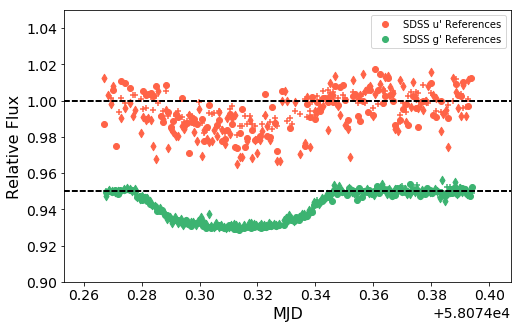

In [553]:
print('\n >>> Starting plots...')

#flux
fig_all_flux_transit = plt.figure(figsize=(8,5))
ax_all_flux_transit = fig_all_flux_transit.add_subplot(1, 1, 1)

for i,filt in enumerate(filt_list):
    result_filter = "*_"+str(filt)+"_*.result"
    res_files = sorted(glob.glob(os.path.join(results_direc, result_filter)))
            
    #time vs airmass
    fig_time_airmass = plt.figure(figsize=(8,5))
    ax_time_airmass = fig_time_airmass.add_subplot(1, 1, 1)
    
    #flux
    fig_flux_airmass = plt.figure(figsize=(8,5))
    ax_flux_airmass = fig_flux_airmass.add_subplot(1, 1, 1)
    
    fig_flux_time = plt.figure(figsize=(8,5))
    ax_flux_time = fig_flux_time.add_subplot(1, 1, 1)
    
    fig_flux_transit = plt.figure(figsize=(8,5))
    ax_flux_transit = fig_flux_transit.add_subplot(1, 1, 1)
    
    for ff,rname in enumerate(res_files):
        with open(rname) as f:
            lines = f.readlines()
            image = [line.split()[0] for line in lines]
            ids = [line.split()[1] for line in lines]
            filts = [line.split()[2] for line in lines]
            otime_mjd = [float(line.split()[3]) for line in lines]
            xairmass = [float(line.split()[4]) for line in lines]
            exptime = [float(line.split()[5]) for line in lines]
            flux = [float(line.split()[6]) for line in lines]
            epadu = [float(line.split()[7]) for line in lines]
            area = [float(line.split()[8]) for line in lines]
            stdev = [float(line.split()[9]) for line in lines]
            nsky = [float(line.split()[10]) for line in lines]
                        
            bkg_mean = [st / ns for st,ns in zip(stdev,nsky)]
            bkg_sum = [bkg * ar for bkg,ar in zip(bkg_mean,area)]
            final_flux = [fl - bkg for fl,bkg in zip(flux,bkg_sum)]
            
            #time vs airmass
            ax_time_airmass.scatter(otime_mjd, xairmass, c=color_array[-i])
            
            #flux
            ax_flux_airmass.scatter(xairmass, final_flux, c=color_array[int(ids[0])])
            ax_flux_time.scatter(otime_mjd, final_flux, c=color_array[int(ids[0])])
            
            if int(ids[0]) == 1:
                flux_star = np.asarray(final_flux)

            else:
                flux_ref = np.asarray(final_flux)
                
                rel_flux = [(s-r)/r+1.0 for s,r in zip(flux_star,flux_ref)]

                mjd_keep_flux, flux_keep = remove_outliers(otime_mjd, rel_flux, 
                                                           sigma=1.0)
                
                for j in range(9):
                    mjd_keep_flux, flux_keep = remove_outliers(mjd_keep_flux, flux_keep, 
                                                               sigma=2.0)
                    j += 1

                out_of_transit_flux = np.append(flux_keep[0:7], flux_keep[-7:])
                out_of_transit_mjd_flux = np.append(mjd_keep_flux[0:7], 
                                                    mjd_keep_flux[-7:])

                c_flux = np.polyfit(out_of_transit_mjd_flux, out_of_transit_flux, 1)

                fit_flux = flux_keep / (c_flux[1] + 
                                        c_flux[0]*mjd_keep_flux)
                
                out_of_transit_flux = np.append(fit_flux[0:8], fit_flux[-50:])
                out_of_transit_mjd_flux = np.append(mjd_keep_flux[0:8], 
                                                    mjd_keep_flux[-50:])

                c_flux = np.polyfit(out_of_transit_mjd_flux, out_of_transit_flux, 2)

                fit_flux = fit_flux / (c_flux[2] + 
                                        c_flux[1]*mjd_keep_flux + 
                                        c_flux[0]*mjd_keep_flux**2.0)

                ax_flux_transit.scatter(mjd_keep_flux, fit_flux, 
                                        c=color_array[int(ids[0])-2], 
                                        label='Reference #'+str(int(ids[0])-1))
                ax_flux_transit.axhline(y=1.00, c='k', ls='--')
                
                if (int(ids[0])-1) == 1:
                    lab = "SDSS "+str(filt)+"' References"
                else:
                    lab = ""
                ax_all_flux_transit.scatter(mjd_keep_flux, fit_flux-0.05*i,
                                            c=color_array[-i], 
                                            marker=marker_array[int(ids[0])-2], 
                                            label=lab)
                ax_all_flux_transit.axhline(y=1.00-0.05*i, c='k', ls='--')

    #time vs airmass
    ax_time_airmass.set_xlabel('MJD', fontsize=16)
    ax_time_airmass.set_ylabel('Airmass', fontsize=16)
    ax_time_airmass.invert_yaxis()
    plt.tight_layout()
    fig_time_airmass.savefig(os.path.join(results_direc,'time_x_'+str(filt)+'.png'),
                             dpi=200)

    #flux
    ax_flux_airmass.set_xlabel('Airmass', fontsize=16)
    ax_flux_airmass.set_ylabel('Instrumental Flux', fontsize=16)
    plt.tight_layout()
    fig_flux_airmass.savefig(os.path.join(results_direc,'flux_x_'+str(filt)+'.png'),
                             dpi=200)

    ax_flux_time.set_xlabel('MJD', fontsize=16)
    ax_flux_time.set_ylabel('Instrumental Flux', fontsize=16)
    plt.tight_layout()
    fig_flux_time.savefig(os.path.join(results_direc,'flux_time_'+str(filt)+'.png'),
                          dpi=200)
    
    ax_flux_transit.set_xlabel('MJD', fontsize=16)
    ax_flux_transit.set_ylabel('Relative Flux', fontsize=16)
    ax_flux_transit.set_ylim(0.95,1.05)
    ax_flux_transit.legend()
    plt.tight_layout()
    fig_flux_transit.savefig(os.path.join(results_direc,'transit_'+str(filt)+'.png'),
                             dpi=200)

ax_all_flux_transit.set_xlabel('MJD', fontsize=16)
ax_all_flux_transit.set_ylabel('Relative Flux', fontsize=16)
ax_all_flux_transit.set_ylim(1.00-0.05*i-0.05,1.05)
ax_all_flux_transit.legend()
plt.tight_layout()
fig_all_flux_transit.savefig(os.path.join(results_direc,'transits_flux.png'),
                             dpi=200)

plt.close()
plt.close()
plt.close()
plt.close()
plt.close()
plt.close()
plt.close()
plt.close()